✅ Semua paket telah terinstall
🏥 PILIHAN MENU:
1. Buat template Excel
2. Jalankan analisis lengkap
3. Analisis dengan data contoh

Pilih menu (1/2/3): 2
🏥 SISTEM ANALISIS KESEHATAN LANSIA DENGAN FUZZY C-MEANS
📂 Silakan upload file Excel Anda:


Saving Nama_BMI_TDS_TDD_KGD_MAP_PP.xlsx to Nama_BMI_TDS_TDD_KGD_MAP_PP (3).xlsx
✅ Data berhasil dimuat dari Nama_BMI_TDS_TDD_KGD_MAP_PP (3).xlsx
📊 Jumlah data: 90 pasien

📋 Kolom yang tersedia: ['Nama', 'BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']
🔄 Memproses dan menormalisasi data...
✅ Normalisasi data selesai!
🎯 Menjalankan Fuzzy C-Means dengan 3 cluster...
✅ Konvergen pada iterasi 16
✅ Fuzzy C-Means clustering selesai!

📊 Menampilkan hasil analisis...


Nama,BMI,TDS,TDD,KGD,MAP,PP
JEMATUN,18.0,136,80,167,99,56
KHODIJAH,17.8,110,70,126,83,40
WARTI,27.4,120,70,141,87,50
KATINAH,26.9,136,76,89,96,60
KAYATIN,28.8,154,73,200,100,81
SUKINAH,23.3,110,70,222,83,40
SARINTEN,20.4,120,72,117,88,48
SUMINAH,27.6,132,77,198,95,55
TUMINEM,28.3,126,77,109,93,49
SUTIANI,24.2,139,67,124,91,72



📈 Membuat visualisasi...


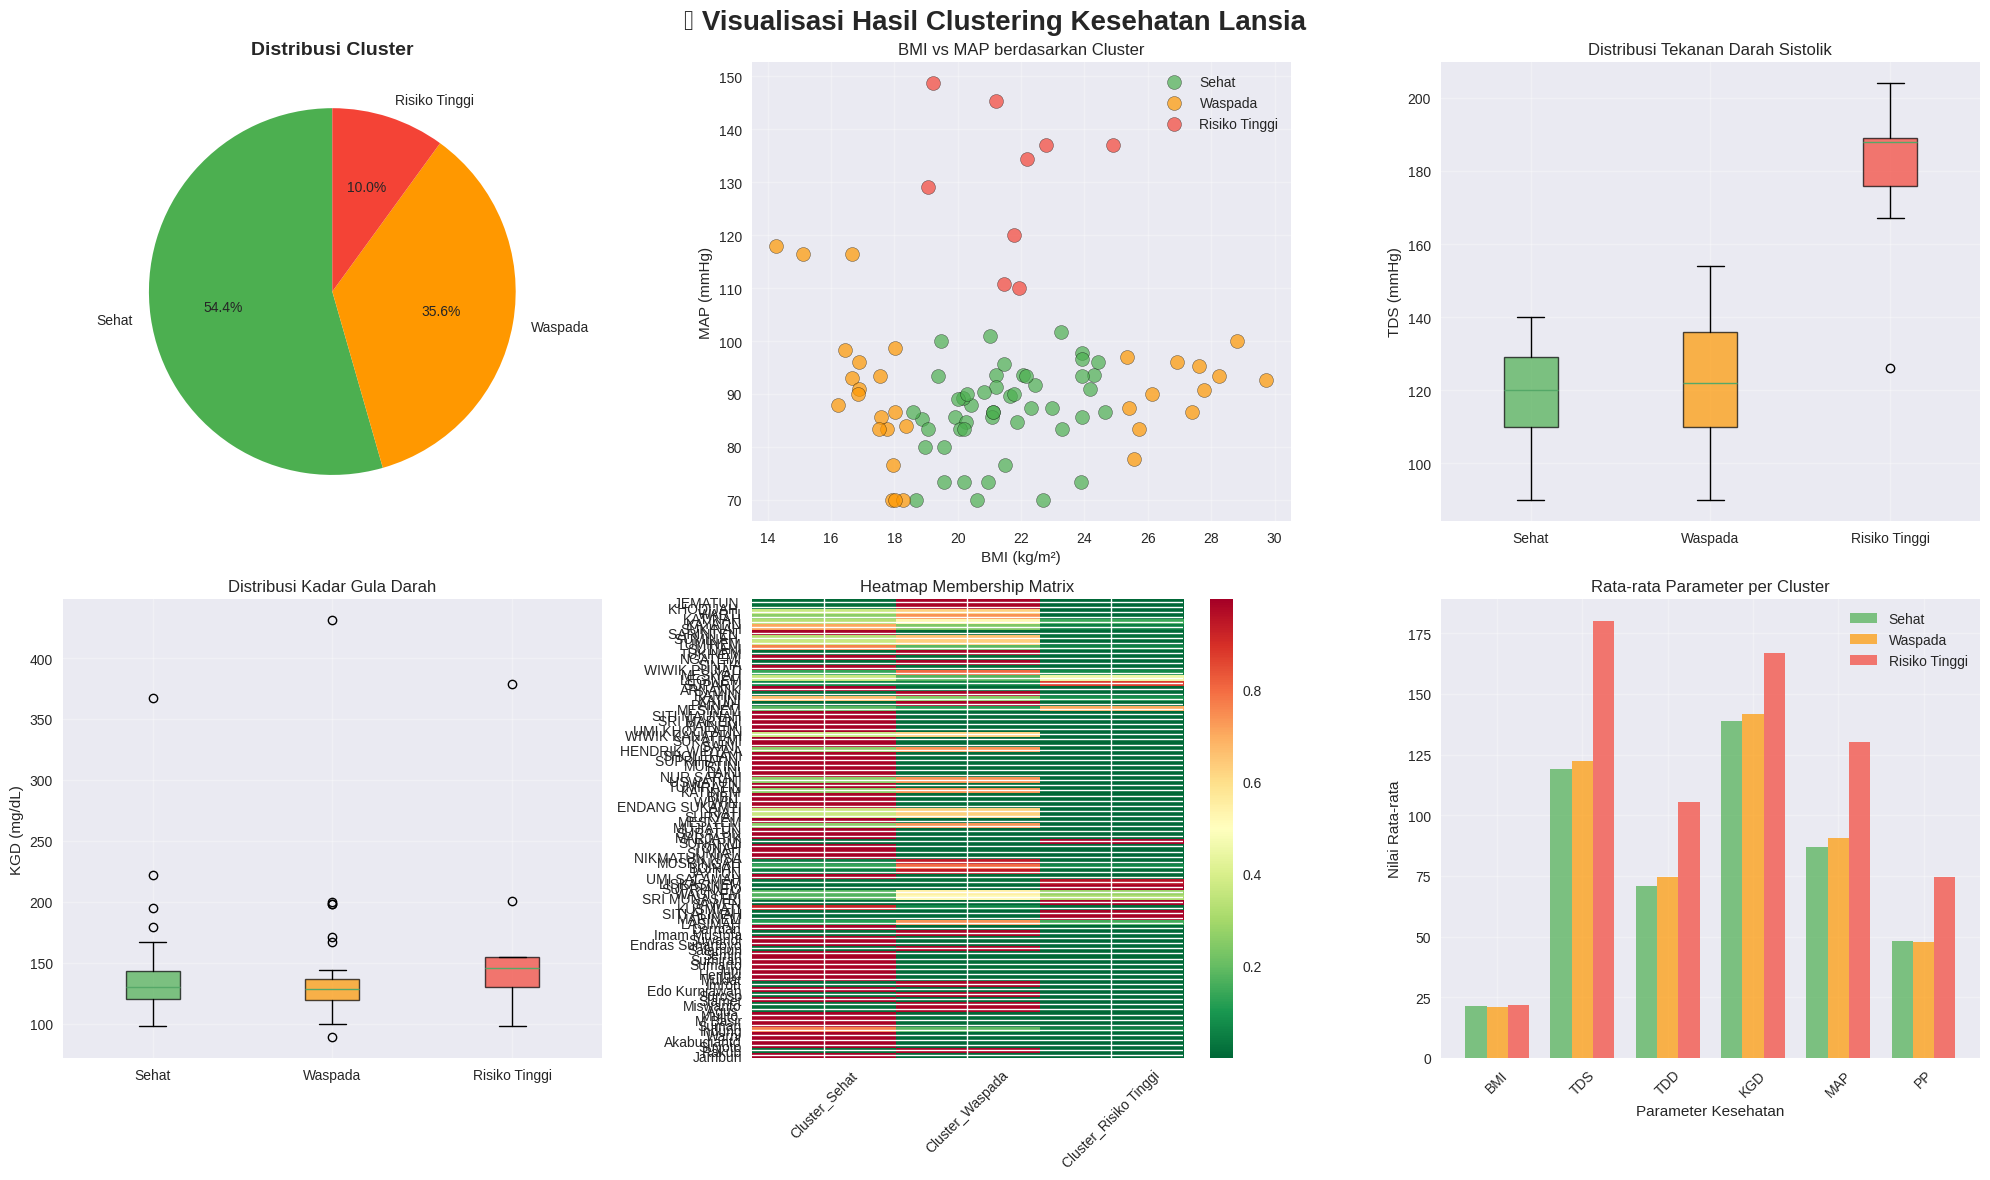


💾 Mengekspor hasil...
✅ Hasil berhasil diekspor ke 'hasil_analisis_kesehatan.xlsx'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Analisis lengkap selesai!
📁 File hasil tersedia untuk diunduh


In [4]:
# Install required packages
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')
!pip install -q pandas numpy matplotlib seaborn plotly scikit-learn openpyxl xlsxwriter
print("✅ Semua paket telah terinstall")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from google.colab import files
from IPython.display import HTML, display
import io
import base64

class FuzzyCMeansHealthAnalysis:
    def __init__(self, random_seed=42):
        self.data = None
        self.normalized_data = None
        self.cluster_results = None
        self.centroids = None
        self.membership_matrix = None
        self.random_seed = random_seed

    def create_template_excel(self):
        """Membuat template Excel untuk input data"""
        template_data = {
            'Nama': ['JEMATUN', 'KHODIJAH', 'WARTI', 'KATINAH', 'KAYATIN', 'SUKINAH'],
            'BMI': [18.0, 17.8, 27.4, 26.9, 28.8, 23.3],
            'TDS': [136, 110, 120, 136, 154, 110],
            'TDD': [80, 70, 70, 76, 200, 70],
            'KGD': [167, 126, 141, 89, 200, 222]
        }

        df_template = pd.DataFrame(template_data)

        # Hitung MAP dan PP
        df_template['MAP'] = ((2 * df_template['TDD']) + df_template['TDS']) / 3
        df_template['PP'] = df_template['TDS'] - df_template['TDD']

        # Simpan ke Excel
        with pd.ExcelWriter('template_data_kesehatan.xlsx', engine='xlsxwriter') as writer:
            df_template.to_excel(writer, sheet_name='Data_Kesehatan', index=False)

            # Tambah sheet instruksi
            instruksi = {
                'Parameter': ['Nama', 'BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP'],
                'Deskripsi': [
                    'Nama lengkap pasien',
                    'Body Mass Index (kg/m²)',
                    'Tekanan Darah Sistolik (mmHg)',
                    'Tekanan Darah Diastolik (mmHg)',
                    'Kadar Gula Darah (mg/dL)',
                    'Mean Arterial Pressure (mmHg) = ((2xTDD)+TDS)/3',
                    'Pulse Pressure (mmHg) = TDS - TDD'
                ],
                'Rentang_Normal': [
                    'Text',
                    '18.5-24.9 kg/m²',
                    '90-140 mmHg',
                    '60-90 mmHg',
                    '70-180 mg/dL',
                    '70-105 mmHg',
                    '30-50 mmHg'
                ]
            }
            pd.DataFrame(instruksi).to_excel(writer, sheet_name='Instruksi', index=False)

        print("✅ Template Excel berhasil dibuat: 'template_data_kesehatan.xlsx'")
        files.download('template_data_kesehatan.xlsx')

    def calculate_map(self, tds, tdd):
        """Menghitung Mean Arterial Pressure"""
        return ((2 * tdd) + tds) / 3

    def calculate_pp(self, tds, tdd):
        """Menghitung Pulse Pressure"""
        return tds - tdd

    def normalize_bmi(self, bmi):
        """Normalisasi BMI sesuai aturan medis"""
        if bmi < 18.5:
            return 1.0  # Underweight - berisiko
        elif 18.5 <= bmi <= 24.9:
            return 0.0  # Normal - sehat
        elif 25 <= bmi <= 29.9:
            return 0.5  # Overweight - waspada
        else:  # bmi >= 30
            return 1.0  # Obese - berisiko tinggi

    def normalize_tds(self, tds):
        """Normalisasi Tekanan Darah Sistolik"""
        if tds < 90:
            return 1.0  # Hipotension - berisiko
        elif 90 <= tds <= 140:
            return 0.0  # Normal - sehat
        elif 140 < tds <= 160:
            return 0.5  # Stage 1 hypertension - waspada
        else:  # tds > 160
            return 1.0  # Stage 2 hypertension - berisiko tinggi

    def normalize_tdd(self, tdd):
        """Normalisasi Tekanan Darah Diastolik"""
        if tdd < 60:
            return 1.0  # Hipotension - berisiko
        elif 60 <= tdd <= 90:
            return 0.0  # Normal - sehat
        elif 90 < tdd <= 100:
            return 0.5  # Stage 1 hypertension - waspada
        else:  # tdd > 100
            return 1.0  # Stage 2 hypertension - berisiko tinggi

    def normalize_kgd(self, kgd):
        """Normalisasi Kadar Gula Darah"""
        if kgd < 70:
            return 1.0  # Hipoglikemia - berisiko
        elif 70 <= kgd <= 180:
            return 0.0  # Normal - sehat
        elif 180 < kgd <= 200:
            return 0.5  # Pre-diabetes - waspada
        else:  # kgd > 200
            return 1.0  # Diabetes - berisiko tinggi

    def normalize_map(self, map_value):
        """Normalisasi Mean Arterial Pressure"""
        if map_value < 70:
            return 1.0  # Terlalu rendah - berisiko
        elif 70 <= map_value <= 105:
            return 0.0  # Normal - sehat
        elif 105 < map_value <= 120:
            return 0.5  # Tinggi - waspada
        else:  # map_value > 120
            return 1.0  # Sangat tinggi - berisiko tinggi

    def normalize_pp(self, pp):
        """Normalisasi Pulse Pressure"""
        if pp < 30:
            return 0.5  # Terlalu rendah - waspada
        elif 30 <= pp <= 50:
            return 0.0  # Normal - sehat
        elif 50 < pp <= 70:
            return 0.5  # Tinggi - waspada
        else:  # pp > 70
            return 1.0  # Sangat tinggi - berisiko tinggi

    def load_data_from_excel(self):
        """Load data dari file Excel yang diupload"""
        print("📂 Silakan upload file Excel Anda:")
        uploaded = files.upload()

        if not uploaded:
            print("❌ Tidak ada file yang diupload!")
            return False

        filename = list(uploaded.keys())[0]

        try:
            self.data = pd.read_excel(filename)

            # Hitung MAP dan PP jika belum ada
            if 'MAP' not in self.data.columns:
                self.data['MAP'] = self.data.apply(lambda row: self.calculate_map(row['TDS'], row['TDD']), axis=1)
            if 'PP' not in self.data.columns:
                self.data['PP'] = self.data.apply(lambda row: self.calculate_pp(row['TDS'], row['TDD']), axis=1)
            print(f"✅ Data berhasil dimuat dari {filename}")
            print(f"📊 Jumlah data: {len(self.data)} pasien")
            print("\n📋 Kolom yang tersedia:", list(self.data.columns))
            return True
        except Exception as e:
            print(f"❌ Error loading file: {str(e)}")
            return False

    def preprocess_data(self):
        """Preprocessing dan normalisasi data"""
        if self.data is None:
            print("❌ Data belum dimuat!")
            return False

        print("🔄 Memproses dan menormalisasi data...")

        # Pastikan MAP dan PP sudah dihitung
        if 'MAP' not in self.data.columns:
            self.data['MAP'] = self.data.apply(lambda row: self.calculate_map(row['TDS'], row['TDD']), axis=1)
        if 'PP' not in self.data.columns:
            self.data['PP'] = self.data.apply(lambda row: self.calculate_pp(row['TDS'], row['TDD']), axis=1)

        # Normalisasi semua parameter
        normalized_features = pd.DataFrame()
        normalized_features['Nama'] = self.data['Nama']
        normalized_features['BMI_Norm'] = self.data['BMI'].apply(self.normalize_bmi)
        normalized_features['TDS_Norm'] = self.data['TDS'].apply(self.normalize_tds)
        normalized_features['TDD_Norm'] = self.data['TDD'].apply(self.normalize_tdd)
        normalized_features['KGD_Norm'] = self.data['KGD'].apply(self.normalize_kgd)
        normalized_features['MAP_Norm'] = self.data['MAP'].apply(self.normalize_map)
        normalized_features['PP_Norm'] = self.data['PP'].apply(self.normalize_pp)

        self.normalized_data = normalized_features
        print("✅ Normalisasi data selesai!")
        return True

    def euclidean_distance(self, point1, point2):
        """Menghitung jarak Euclidean"""
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def fuzzy_cmeans_clustering(self, n_clusters=3, m=1.5, max_iter=1000, tolerance=1e-5):
        """Implementasi Fuzzy C-Means dengan hasil konsisten"""
        if self.normalized_data is None:
            print("❌ Data belum dinormalisasi!")
            return False

        print(f"🎯 Menjalankan Fuzzy C-Means dengan {n_clusters} cluster...")

        # Set seed untuk konsistensi
        np.random.seed(self.random_seed)

        # Ambil feature untuk clustering (exclude nama)
        features = ['BMI_Norm', 'TDS_Norm', 'TDD_Norm', 'KGD_Norm', 'MAP_Norm', 'PP_Norm']
        X = self.normalized_data[features].values
        n_points, n_features = X.shape

        # Inisialisasi membership matrix yang lebih stabil
        # Gunakan K-means untuk inisialisasi awal
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_seed, n_init=10)
        initial_labels = kmeans.fit_predict(X)

        # Buat membership matrix berdasarkan hasil K-means
        U = np.zeros((n_points, n_clusters))
        for i in range(n_points):
            U[i, initial_labels[i]] = 0.9  # Membership tinggi untuk cluster yang diprediksi
            # Sisa membership dibagi rata untuk cluster lain
            remaining = 0.1
            for j in range(n_clusters):
                if j != initial_labels[i]:
                    U[i, j] = remaining / (n_clusters - 1)

        # Inisialisasi centroids
        centroids = np.zeros((n_clusters, n_features))

        for iteration in range(max_iter):
            # Update centroids
            U_m = U ** m
            for i in range(n_clusters):
                centroids[i] = np.sum(U_m[:, i:i+1] * X, axis=0) / np.sum(U_m[:, i])

            # Update membership matrix
            U_new = np.zeros((n_points, n_clusters))
            for i in range(n_points):
                for j in range(n_clusters):
                    distances = [self.euclidean_distance(X[i], centroids[k]) for k in range(n_clusters)]
                    if distances[j] == 0:
                        U_new[i, j] = 1.0
                    else:
                        sum_term = sum([(distances[j] / max(distances[k], 1e-10)) ** (2 / (m - 1)) for k in range(n_clusters)])
                        U_new[i, j] = 1.0 / sum_term

            # Check convergence
            if np.linalg.norm(U - U_new) < tolerance:
                print(f"✅ Konvergen pada iterasi {iteration + 1}")
                break

            U = U_new

        # Konsistensi penamaan cluster berdasarkan karakteristik
        # Hitung rata-rata risiko untuk setiap cluster
        cluster_assignments = np.argmax(U, axis=1)
        cluster_risk_scores = []

        for i in range(n_clusters):
            cluster_mask = cluster_assignments == i
            if np.sum(cluster_mask) > 0:
                # Hitung skor risiko rata-rata (semakin tinggi semakin berisiko)
                cluster_data = X[cluster_mask]
                risk_score = np.mean(cluster_data, axis=0).mean()  # Rata-rata semua parameter
                cluster_risk_scores.append((i, risk_score))

        # Urutkan cluster berdasarkan skor risiko
        cluster_risk_scores.sort(key=lambda x: x[1])

        # Mapping cluster: risiko terendah = Sehat, tertinggi = Risiko Tinggi
        cluster_mapping = {}
        cluster_names = ['Sehat', 'Waspada', 'Risiko Tinggi']

        for idx, (original_cluster, _) in enumerate(cluster_risk_scores):
            cluster_mapping[original_cluster] = idx

        # Terapkan mapping ke hasil clustering
        mapped_assignments = np.array([cluster_mapping[cluster] for cluster in cluster_assignments])

        # Reorder membership matrix sesuai mapping
        U_mapped = np.zeros_like(U)
        centroids_mapped = np.zeros_like(centroids)

        for original_idx, mapped_idx in cluster_mapping.items():
            U_mapped[:, mapped_idx] = U[:, original_idx]
            centroids_mapped[mapped_idx] = centroids[original_idx]

        self.membership_matrix = U_mapped
        self.centroids = centroids_mapped

        # Buat hasil clustering
        self.cluster_results = self.normalized_data.copy()
        self.cluster_results['Cluster'] = mapped_assignments
        self.cluster_results['Cluster_Name'] = self.cluster_results['Cluster'].map({
            0: 'Sehat', 1: 'Waspada', 2: 'Risiko Tinggi'
        })

        # Tambah membership scores
        for i in range(n_clusters):
            cluster_names = ['Sehat', 'Waspada', 'Risiko Tinggi']
            self.cluster_results[f'Cluster_{cluster_names[i]}'] = U_mapped[:, i]

        print("✅ Fuzzy C-Means clustering selesai!")
        return True

    def display_results(self):
        """Menampilkan hasil clustering dalam HTML dengan Min-Max Normalization"""
        if self.cluster_results is None:
            print("❌ Clustering belum dilakukan!")
            return

        # Gabungkan dengan data original
        results_display = pd.merge(self.data, self.cluster_results[['Nama', 'Cluster', 'Cluster_Name',
                                                                  'Cluster_Sehat', 'Cluster_Waspada',
                                                                  'Cluster_Risiko Tinggi']], on='Nama')

        # HTML styling
        html_template = """
            <style>
            .health-analysis {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                max-width: 1200px;
                margin: 20px auto;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                padding: 30px;
                border-radius: 15px;
                color: white;
            }}

            .title {{
                text-align: center;
                font-size: 2.5em;
                margin-bottom: 30px;
                text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
            }}

            .section {{
                background: rgba(255,255,255,0.95);
                color: #000000;
                margin: 20px 0;
                padding: 25px;
                border-radius: 10px;
                box-shadow: 0 5px 15px rgba(0,0,0,0.1);
            }}

            .section h3 {{
                color: #667eea;
                border-bottom: 2px solid #667eea;
                padding-bottom: 10px;
                margin-bottom: 20px;
            }}

            table {{
                width: 100%;
                border-collapse: collapse;
                margin: 15px 0;
                background: white;
                border-radius: 8px;
                overflow: hidden;
                box-shadow: 0 3px 10px rgba(0,0,0,0.1);
                color: #000000;
            }}

            th, td {{
                padding: 12px;
                text-align: center;
                border-bottom: 1px solid #e0e0e0;
                color: #000000;
            }}

            th {{
                background: linear-gradient(45deg, #667eea, #764ba2);
                color: white;
                font-weight: 600;
            }}

            .cluster-sehat {{ background-color: #e8f5e8 !important; color: #2e7d32 !important; font-weight: bold; }}
            .cluster-waspada {{ background-color: #fff3e0 !important; color: #ef6c00 !important; font-weight: bold; }}
            .cluster-risiko {{ background-color: #ffebee !important; color: #c62828 !important; font-weight: bold; }}

            .summary-cards {{
                display: flex;
                justify-content: space-around;
                margin: 20px 0;
                flex-wrap: wrap;
            }}

            .card {{
                background: white;
                padding: 20px;
                border-radius: 10px;
                text-align: center;
                margin: 10px;
                flex: 1;
                min-width: 200px;
                box-shadow: 0 5px 15px rgba(0,0,0,0.1);
                color: #000000;
            }}

            .card-sehat {{ border-left: 5px solid #4CAF50; }}
            .card-waspada {{ border-left: 5px solid #FF9800; }}
            .card-risiko {{ border-left: 5px solid #F44336; }}

            .card h4 {{ margin: 0 0 10px 0; color: #000000; }}
            .card .number {{ font-size: 2em; font-weight: bold; color: #000000; }}

            .normalization-info {{
                background: #e3f2fd;
                padding: 15px;
                border-radius: 8px;
                border-left: 4px solid #2196f3;
                margin-bottom: 20px;
                color: #000000;
            }}

            .normalization-info h4 {{
                color: #000000;
            }}

            .normalization-info p {{
                color: #000000;
            }}

            .normalization-info ul {{
                color: #000000;
            }}

            .normalization-info li {{
                color: #000000;
            }}
        </style>

        <div class="health-analysis">
            <h1 class="title">🏥 Hasil Analisis Kesehatan Lansia dengan Fuzzy C-Means</h1>

            <div class="section">
                <h3>📊 Ringkasan Hasil Clustering</h3>
                <div class="summary-cards">
                    <div class="card card-sehat">
                        <h4>🟢 SEHAT</h4>
                        <div class="number">{sehat_count}</div>
                        <p>Pasien</p>
                    </div>
                    <div class="card card-waspada">
                        <h4>🟡 WASPADA</h4>
                        <div class="number">{waspada_count}</div>
                        <p>Pasien</p>
                    </div>
                    <div class="card card-risiko">
                        <h4>🔴 RISIKO TINGGI</h4>
                        <div class="number">{risiko_count}</div>
                        <p>Pasien</p>
                    </div>
                </div>
            </div>

            <div class="section">
                <h3>📋 Data Original dengan Parameter Lengkap</h3>
                {original_table}
            </div>

            <div class="section">
                <h3>🧮 Data Normalisasi (Min-Max Normalization)</h3>
                <div class="normalization-info">
                    <h4>🔧 Min-Max Normalization Formula:</h4>
                    <p><strong>X_normalized = (X - X_min) / (X_max - X_min)</strong></p>
                    <p>Mengubah semua nilai ke rentang [0, 1] berdasarkan nilai minimum dan maksimum dari setiap parameter.</p>
                    <ul>
                        <li><strong>Nilai 0:</strong> Nilai terendah dalam dataset</li>
                        <li><strong>Nilai 1:</strong> Nilai tertinggi dalam dataset</li>
                        <li><strong>Nilai 0-1:</strong> Posisi relatif antara minimum dan maksimum</li>
                    </ul>
                </div>
                {normalized_table}
            </div>

            <div class="section">
                <h3>🎯 Hasil Clustering dengan Fuzzy C-Means</h3>
                {results_table}
            </div>

            <div class="section">
                <h3>📈 Interpretasi Hasil</h3>
                <div style="background: #f8f9ff; padding: 20px; border-radius: 8px; border-left: 4px solid #667eea; color: #000000;">
                    <h4 style="color: #000000;">Parameter yang Dianalisis:</h4>
                    <ul style="color: #000000;">
                        <li><strong>BMI:</strong> Body Mass Index - Indeks massa tubuh</li>
                        <li><strong>TDS:</strong> Tekanan Darah Sistolik</li>
                        <li><strong>TDD:</strong> Tekanan Darah Diastolik</li>
                        <li><strong>KGD:</strong> Kadar Gula Darah</li>
                        <li><strong>MAP:</strong> Mean Arterial Pressure = ((2×TDD)+TDS)/3</li>
                        <li><strong>PP:</strong> Pulse Pressure = TDS - TDD</li>
                    </ul>

                    <h4 style="color: #000000;">🟢 Cluster SEHAT:</h4>
                    <p style="color: #000000;">Parameter kesehatan dalam rentang normal atau mendekati normal. Risiko komplikasi rendah.</p>

                    <h4 style="color: #000000;">🟡 Cluster WASPADA:</h4>
                    <p style="color: #000000;">Beberapa parameter di luar rentang normal. Memerlukan monitoring dan intervensi preventif.</p>

                    <h4 style="color: #000000;">🔴 Cluster RISIKO TINGGI:</h4>
                    <p style="color: #000000;">Multiple parameter abnormal. Memerlukan intervensi medis segera dan monitoring ketat.</p>

                    <p style="color: #000000;"><strong>Catatan:</strong> Membership scores menunjukkan seberapa kuat keanggotaan pasien pada setiap cluster.
                    Semakin tinggi nilai membership, semakin kuat keanggotaan pada cluster tersebut.</p>
                </div>
            </div>

        """

        # Hitung summary
        sehat_count = len(results_display[results_display['Cluster_Name'] == 'Sehat'])
        waspada_count = len(results_display[results_display['Cluster_Name'] == 'Waspada'])
        risiko_count = len(results_display[results_display['Cluster_Name'] == 'Risiko Tinggi'])

        # Implementasi Min-Max Normalization
        def apply_minmax_normalization(data):
            """Terapkan Min-Max Normalization pada data numerik"""
            numeric_columns = ['BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']
            normalized_data = data.copy()

            for col in numeric_columns:
                if col in data.columns:
                    min_val = data[col].min()
                    max_val = data[col].max()
                    # Hindari pembagian dengan nol
                    if max_val != min_val:
                        # Min-Max Normalization: (X - min) / (max - min)
                        normalized_data[col] = (data[col] - min_val) / (max_val - min_val)
                    else:
                        # Jika semua nilai sama, set ke 0
                        normalized_data[col] = 0

            return normalized_data

        # Terapkan Min-Max Normalization
        minmax_normalized_data = apply_minmax_normalization(self.data)

        # Format tables
        def format_table_with_cluster_colors(df, include_cluster=False, is_normalized=False):
            html = "<table><thead><tr>"
            for col in df.columns:
                html += f"<th>{col}</th>"
            html += "</tr></thead><tbody>"

            for _, row in df.iterrows():
                if include_cluster:
                    if row['Cluster_Name'] == 'Sehat':
                        row_class = 'cluster-sehat'
                    elif row['Cluster_Name'] == 'Waspada':
                        row_class = 'cluster-waspada'
                    else:
                        row_class = 'cluster-risiko'
                    html += f'<tr class="{row_class}">'
                else:
                    html += '<tr>'

                for col in df.columns:
                    if pd.api.types.is_numeric_dtype(df[col]) and col not in ['BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP', 'Cluster']:
                        html += f"<td>{row[col]:.4f}</td>"
                    elif pd.api.types.is_numeric_dtype(df[col]):
                        if is_normalized and col in ['BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']:
                            # Untuk data normalized, tampilkan 4 desimal
                            html += f"<td>{row[col]:.4f}</td>"
                        elif col == 'BMI' and not is_normalized:
                            # Untuk data asli BMI, tampilkan 1 desimal
                            html += f"<td>{row[col]:.1f}</td>"
                        elif col in ['TDS', 'TDD', 'KGD', 'MAP', 'PP'] and not is_normalized:
                            # Untuk data asli lainnya, tampilkan tanpa desimal
                            html += f"<td>{row[col]:.0f}</td>"
                        else:
                            html += f"<td>{row[col]:.4f}</td>"
                    else:
                        html += f"<td>{row[col]}</td>"
                html += "</tr>"

            html += "</tbody></table>"
            return html

        # Create tables
        original_display = self.data.copy()
        original_table = format_table_with_cluster_colors(original_display, is_normalized=False)

        # Gunakan data yang sudah dinormalisasi dengan Min-Max
        normalized_table = format_table_with_cluster_colors(minmax_normalized_data, is_normalized=True)

        results_table = format_table_with_cluster_colors(results_display[['Nama', 'Cluster_Name', 'Cluster_Sehat',
                                                                        'Cluster_Waspada', 'Cluster_Risiko Tinggi']],
                                                       include_cluster=True)

        # Format HTML
        html_output = html_template.format(
            sehat_count=sehat_count,
            waspada_count=waspada_count,
            risiko_count=risiko_count,
            original_table=original_table,
            normalized_table=normalized_table,
            results_table=results_table
        )

        display(HTML(html_output))

    def create_visualizations(self):
        """Membuat visualisasi hasil clustering"""
        if self.cluster_results is None:
            print("❌ Clustering belum dilakukan!")
            return

        # Gabungkan dengan data original
        viz_data = pd.merge(self.data, self.cluster_results[['Nama', 'Cluster', 'Cluster_Name']], on='Nama')

        # Set style
        plt.style.use('seaborn-v0_8')
        colors = ['#4CAF50', '#FF9800', '#F44336']  # Sehat, Waspada, Risiko

        # Create subplots
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('📊 Visualisasi Hasil Clustering Kesehatan Lansia', fontsize=20, fontweight='bold')

        # 1. Distribusi Cluster
        cluster_counts = viz_data['Cluster_Name'].value_counts()
        axes[0, 0].pie(cluster_counts.values, labels=cluster_counts.index, autopct='%1.1f%%',
                      colors=colors, startangle=90)
        axes[0, 0].set_title('Distribusi Cluster', fontsize=14, fontweight='bold')

        # 2. Scatter plot BMI vs MAP
        for i, cluster in enumerate(['Sehat', 'Waspada', 'Risiko Tinggi']):
            data_subset = viz_data[viz_data['Cluster_Name'] == cluster]
            axes[0, 1].scatter(data_subset['BMI'], data_subset['MAP'],
                             c=colors[i], label=cluster, s=100, alpha=0.7, edgecolors='black')
        axes[0, 1].set_xlabel('BMI (kg/m²)')
        axes[0, 1].set_ylabel('MAP (mmHg)')
        axes[0, 1].set_title('BMI vs MAP berdasarkan Cluster')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Box plot TDS berdasarkan cluster
        cluster_data = [viz_data[viz_data['Cluster_Name'] == cluster]['TDS'] for cluster in ['Sehat', 'Waspada', 'Risiko Tinggi']]
        bp1 = axes[0, 2].boxplot(cluster_data, labels=['Sehat', 'Waspada', 'Risiko Tinggi'], patch_artist=True)
        for patch, color in zip(bp1['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[0, 2].set_title('Distribusi Tekanan Darah Sistolik')
        axes[0, 2].set_ylabel('TDS (mmHg)')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. Box plot KGD berdasarkan cluster
        cluster_data_kgd = [viz_data[viz_data['Cluster_Name'] == cluster]['KGD'] for cluster in ['Sehat', 'Waspada', 'Risiko Tinggi']]
        bp2 = axes[1, 0].boxplot(cluster_data_kgd, labels=['Sehat', 'Waspada', 'Risiko Tinggi'], patch_artist=True)
        for patch, color in zip(bp2['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
        axes[1, 0].set_title('Distribusi Kadar Gula Darah')
        axes[1, 0].set_ylabel('KGD (mg/dL)')
        axes[1, 0].grid(True, alpha=0.3)

                # 5. Heatmap membership matrix
        membership_data = self.cluster_results[['Nama', 'Cluster_Sehat', 'Cluster_Waspada', 'Cluster_Risiko Tinggi']].set_index('Nama')
        im = axes[1, 1].imshow(membership_data.values, cmap='RdYlGn_r', aspect='auto')
        axes[1, 1].set_xticks(range(len(membership_data.columns)))
        axes[1, 1].set_xticklabels(membership_data.columns, rotation=45)
        axes[1, 1].set_yticks(range(len(membership_data.index)))
        axes[1, 1].set_yticklabels(membership_data.index)
        axes[1, 1].set_title('Heatmap Membership Matrix')
        plt.colorbar(im, ax=axes[1, 1])

        # 6. Bar chart parameter kesehatan rata-rata per cluster
        health_params = ['BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']
        cluster_means = viz_data.groupby('Cluster_Name')[health_params].mean()

        x = np.arange(len(health_params))
        width = 0.25

        for i, cluster in enumerate(['Sehat', 'Waspada', 'Risiko Tinggi']):
            axes[1, 2].bar(x + i*width, cluster_means.loc[cluster], width,
                          label=cluster, color=colors[i], alpha=0.7)

        axes[1, 2].set_xlabel('Parameter Kesehatan')
        axes[1, 2].set_ylabel('Nilai Rata-rata')
        axes[1, 2].set_title('Rata-rata Parameter per Cluster')
        axes[1, 2].set_xticks(x + width)
        axes[1, 2].set_xticklabels(health_params, rotation=45)
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Interactive Plotly visualization
        self.create_interactive_plots(viz_data)

    def create_interactive_plots(self, viz_data):
        """Membuat plot interaktif dengan Plotly"""
        # 3D Scatter plot
        fig = px.scatter_3d(viz_data, x='BMI', y='TDS', z='KGD',
                           color='Cluster_Name',
                           hover_data=['Nama', 'TDD', 'MAP', 'PP'],
                           color_discrete_map={'Sehat': '#4CAF50', 'Waspada': '#FF9800', 'Risiko Tinggi': '#F44336'},
                           title='📊 Visualisasi 3D: BMI vs TDS vs KGD')
        fig.update_layout(height=600)
        fig.show()

        # Radar chart untuk centroid
        categories = ['BMI_Norm', 'TDS_Norm', 'TDD_Norm', 'KGD_Norm', 'MAP_Norm', 'PP_Norm']

        fig = go.Figure()

        cluster_names = ['Sehat', 'Waspada', 'Risiko Tinggi']
        colors_rgba = ['rgba(76, 175, 80, 0.6)', 'rgba(255, 152, 0, 0.6)', 'rgba(244, 67, 54, 0.6)']

        for i, (cluster_name, color) in enumerate(zip(cluster_names, colors_rgba)):
            if i < len(self.centroids):
                fig.add_trace(go.Scatterpolar(
                    r=self.centroids[i],
                    theta=categories,
                    fill='toself',
                    name=cluster_name,
                    line_color=color.replace('0.6', '1.0'),
                    fillcolor=color
                ))

        fig.update_layout(
            polar=dict(
                radialaxis=dict(
                    visible=True,
                    range=[0, 1]
                )),
            showlegend=True,
            title="📊 Radar Chart - Centroids Cluster"
        )
        fig.show()

    def export_results(self):
        """Export hasil ke Excel"""
        if self.cluster_results is None:
            print("❌ Clustering belum dilakukan!")
            return

        # Gabungkan semua data
        final_results = pd.merge(self.data, self.cluster_results[['Nama', 'Cluster', 'Cluster_Name',
                                                                'Cluster_Sehat', 'Cluster_Waspada',
                                                                'Cluster_Risiko Tinggi']], on='Nama')

        # Tambah interpretasi
        def get_interpretation(row):
            if row['Cluster_Name'] == 'Sehat':
                return "Parameter kesehatan dalam rentang normal. Lanjutkan pola hidup sehat."
            elif row['Cluster_Name'] == 'Waspada':
                return "Beberapa parameter perlu perhatian. Konsultasi dengan dokter dan monitoring rutin."
            else:
                return "Multiple parameter abnormal. Segera konsultasi dokter dan intervensi medis."

        final_results['Interpretasi'] = final_results.apply(get_interpretation, axis=1)

        # Export ke Excel
        with pd.ExcelWriter('hasil_analisis_kesehatan.xlsx', engine='xlsxwriter') as writer:
            # Sheet 1: Hasil Lengkap
            final_results.to_excel(writer, sheet_name='Hasil_Lengkap', index=False)

            # Sheet 2: Summary
            summary_data = {
                'Cluster': ['Sehat', 'Waspada', 'Risiko Tinggi'],
                'Jumlah': [
                    len(final_results[final_results['Cluster_Name'] == 'Sehat']),
                    len(final_results[final_results['Cluster_Name'] == 'Waspada']),
                    len(final_results[final_results['Cluster_Name'] == 'Risiko Tinggi'])
                ],
                'Persentase': [
                    len(final_results[final_results['Cluster_Name'] == 'Sehat']) / len(final_results) * 100,
                    len(final_results[final_results['Cluster_Name'] == 'Waspada']) / len(final_results) * 100,
                    len(final_results[final_results['Cluster_Name'] == 'Risiko Tinggi']) / len(final_results) * 100
                ]
            }
            pd.DataFrame(summary_data).to_excel(writer, sheet_name='Summary', index=False)

            # Sheet 3: Data Normalisasi
            self.normalized_data.to_excel(writer, sheet_name='Data_Normalisasi', index=False)

            # Sheet 4: Centroids
            if self.centroids is not None:
                centroids_df = pd.DataFrame(self.centroids,
                                          columns=['BMI_Norm', 'TDS_Norm', 'TDD_Norm', 'KGD_Norm', 'MAP_Norm', 'PP_Norm'])
                centroids_df.index = ['Sehat', 'Waspuda', 'Risiko Tinggi']
                centroids_df.to_excel(writer, sheet_name='Centroids')

        print("✅ Hasil berhasil diekspor ke 'hasil_analisis_kesehatan.xlsx'")
        files.download('hasil_analisis_kesehatan.xlsx')

        # Fungsi untuk menjalankan analisis
    def run_complete_analysis(self):
        """Menjalankan analisis lengkap"""
        print("🏥 SISTEM ANALISIS KESEHATAN LANSIA DENGAN FUZZY C-MEANS")
        print("=" * 60)

        # Load data
        if not self.load_data_from_excel():
            print("❌ Gagal memuat data. Proses dihentikan.")
            return

        # Preprocessing
        if not self.preprocess_data():
            print("❌ Gagal preprocessing data. Proses dihentikan.")
            return

        # Clustering
        if not self.fuzzy_cmeans_clustering():
            print("❌ Gagal melakukan clustering. Proses dihentikan.")
            return

        # Display results
        print("\n📊 Menampilkan hasil analisis...")
        self.display_results()

        # Create visualizations
        print("\n📈 Membuat visualisasi...")
        self.create_visualizations()

        # Export results
        print("\n💾 Mengekspor hasil...")
        self.export_results()

        print("\n✅ Analisis lengkap selesai!")
        print("📁 File hasil tersedia untuk diunduh")

# Fungsi untuk menjalankan analisis
def run_health_analysis():
    """Fungsi utama untuk menjalankan analisis"""
    analyzer = FuzzyCMeansHealthAnalysis(random_seed=42)

    print("🏥 PILIHAN MENU:")
    print("1. Buat template Excel")
    print("2. Jalankan analisis lengkap")
    print("3. Analisis dengan data contoh")

    choice = input("\nPilih menu (1/2/3): ").strip()

    if choice == "1":
        analyzer.create_template_excel()
    elif choice == "2":
        analyzer.run_complete_analysis()
    elif choice == "3":
        # Gunakan data contoh
        sample_data = {
            'Nama': ['JEMATUN', 'KHODIJAH', 'WARTI', 'KATINAH', 'KAYATIN', 'SUKINAH'],
            'BMI': [18.0, 17.8, 27.4, 26.9, 28.8, 23.3],
            'TDS': [136, 110, 120, 136, 154, 110],
            'TDD': [80, 70, 70, 76, 200, 70],
            'KGD': [167, 126, 141, 89, 200, 222]
        }

        analyzer.data = pd.DataFrame(sample_data)
        # Hitung MAP dan PP
        analyzer.data['MAP'] = analyzer.data.apply(lambda row: analyzer.calculate_map(row['TDS'], row['TDD']), axis=1)
        analyzer.data['PP'] = analyzer.data.apply(lambda row: analyzer.calculate_pp(row['TDS'], row['TDD']), axis=1)
        print("✅ Data contoh berhasil dimuat")

        # Preprocessing
        if analyzer.preprocess_data():
            # Clustering
            if analyzer.fuzzy_cmeans_clustering():
                # Display results
                analyzer.display_results()
                # Create visualizations
                analyzer.create_visualizations()
                # Export results
                analyzer.export_results()
                print("\n✅ Analisis dengan data contoh selesai!")
    else:
        print("❌ Pilihan tidak valid!")

# Jalankan analisis
if __name__ == "__main__":
    run_health_analysis()